# 1.1 붓꽃 품종 예측하기

In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family='NanumGothic') # 폰트 설정
mpl.rc('axes', unicode_minus=False) # 유니코드에서 음수 부호 설정

# 차트 스타일 설정
sns.set(font="NanumGothic", rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc("figure", figsize=(10,8))

warnings.filterwarnings("ignore")

**Iris 데이터 불러오기**

In [3]:
from sklearn.datasets import load_iris

iris = load_iris()
iris_X = iris.data
iris_y = iris.target

iris_df = pd.DataFrame(iris_X, columns = iris.feature_names)
iris_df["species"] = iris_y

iris_df.tail(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2
149,5.9,3.0,5.1,1.8,2


**학습/검증 데이터 분리**

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(iris_X, iris_y, test_size =0.2, random_state = 11)

**의사결정나무 객체 생성**

In [5]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state = 1017)

**성능 평가**

In [6]:
from sklearn.metrics import accuracy_score

dt_clf.fit(X_train, y_train)
pred = dt_clf.predict(X_test)
acc = accuracy_score(y_test,pred)

print(f"예측 정확도: {acc:.3f}")

예측 정확도: 0.867


# 1.2 교차 검증

## 1.2.1 K-Fold 교차 검증

**K-Fold 교차 검증**

In [7]:
from sklearn.model_selection import KFold

cv_accuracy = []
cv = KFold(5)
df_clf = DecisionTreeClassifier(random_state = 1017)

for i, (train_idx, test_idx) in enumerate(cv.split(iris_df)):
    X_train, X_test = iris_X[train_idx], iris_X[test_idx]
    y_train, y_test = iris_y[train_idx], iris_y[test_idx]
    
    # 학습 및 예측
    dt_clf.fit(X_train,y_train)
    pred = dt_clf.predict(X_test)
    
    # 평가: Accuracy
    accuracy = accuracy_score(y_test,pred)
    train_size = train_idx.shape[0]
    test_size = test_idx.shape[0]
    
    print(f"#{i+1}. 학습 데이터 크기: {train_size}, 검증 데이터 크기: {test_size}, 검증 정확도: {accuracy:.3f}")
    
    cv_accuracy.append(accuracy)
    
print(f"### 평균 검증 정확도: {np.mean(cv_accuracy):.3f}")

#1. 학습 데이터 크기: 120, 검증 데이터 크기: 30, 검증 정확도: 1.000
#2. 학습 데이터 크기: 120, 검증 데이터 크기: 30, 검증 정확도: 1.000
#3. 학습 데이터 크기: 120, 검증 데이터 크기: 30, 검증 정확도: 0.900
#4. 학습 데이터 크기: 120, 검증 데이터 크기: 30, 검증 정확도: 0.933
#5. 학습 데이터 크기: 120, 검증 데이터 크기: 30, 검증 정확도: 0.733
### 평균 검증 정확도: 0.913


**K-Fold 문제점**

**붓꽃 품종별 데이터 갯수**

In [8]:
iris_df.species.value_counts()

2    50
1    50
0    50
Name: species, dtype: int64

- 각 품종별로 데이터의 갯수가 동일하다.

**Fold별 데이터 분포**

In [9]:
cv = KFold(3)


for i, (train_idx, test_idx) in enumerate(cv.split(iris_df)):
    iris_train = iris_df.iloc[train_idx]
    iris_test = iris_df.iloc[test_idx]
    
    temp1 = iris_train["species"].value_counts()
    temp2 = iris_test["species"].value_counts()
    temp3 = pd.concat([temp1,temp2], axis=1).fillna(0).astype(int)
    temp3.columns = ["trian","test"]
    
    print(f"#교차 검증: {i+1}")
    print(temp3)

#교차 검증: 1
   trian  test
0      0    50
1     50     0
2     50     0
#교차 검증: 2
   trian  test
0     50     0
1      0    50
2     50     0
#교차 검증: 3
   trian  test
0     50     0
1     50     0
2      0    50


- 첫 번째 교차 검증에서는 학습 데이터에 0이 1개도 없으며, 두 번째, 세 번째에는 각각 1,2가 없다.


- 학습/검증 데이터가 위와 같이 분리되면 검증 예측 정확도는 0이 될 것이다.

## 1.2.2 Stratifed K-Fold 교차 검증

Stratifed K-Fold는 불균형한 분포를 가진 데이터 집합을 위한 K-Fold 방식으로 전체 데이터의 분포도를 반영해서 학습/검증 데이터를 나눈다.

In [10]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(3)

for i, (train_idx, test_idx) in enumerate(skf.split(iris_df, iris_df.species)):
    iris_train = iris_df.iloc[train_idx]
    iris_test = iris_df.iloc[test_idx]
    
    temp1 = iris_train["species"].value_counts()
    temp2 = iris_test["species"].value_counts()
    temp3 = pd.concat([temp1,temp2], axis=1).fillna(0).astype(int)
    temp3.columns = ["trian","test"]
    
    print(f"#교차 검증: {i+1}")
    print(temp3)

#교차 검증: 1
   trian  test
0     33    17
1     33    17
2     34    16
#교차 검증: 2
   trian  test
0     33    17
1     34    16
2     33    17
#교차 검증: 3
   trian  test
0     34    16
1     33    17
2     33    17


- 각 교차 검증에서 전체 데이터 분포와 같이 학습/검증 데이터가 나누어진 것을 확인할 수 있다.

**Stratifed K-Fold 교차 검증**

In [11]:
cv_accuracy = []
skf = StratifiedKFold(3)
df_clf = DecisionTreeClassifier(random_state = 1017)

for i, (train_idx, test_idx) in enumerate(skf.split(iris_df, iris_df.species)):
    X_train, X_test = iris_X[train_idx], iris_X[test_idx]
    y_train, y_test = iris_y[train_idx], iris_y[test_idx]
    
    # 학습 및 예측
    dt_clf.fit(X_train,y_train)
    pred = dt_clf.predict(X_test)
    
    # 평가: Accuracy
    accuracy = accuracy_score(y_test,pred)
    train_size = train_idx.shape[0]
    test_size = test_idx.shape[0]
    
    print(f"#{i+1}. 학습 데이터 크기: {train_size}, 검증 데이터 크기: {test_size}, 검증 정확도: {accuracy:.3f}")
    
    cv_accuracy.append(accuracy)
    
print(f"## 평균 검증 정확도: {np.mean(cv_accuracy):.3f}")

#1. 학습 데이터 크기: 100, 검증 데이터 크기: 50, 검증 정확도: 0.980
#2. 학습 데이터 크기: 100, 검증 데이터 크기: 50, 검증 정확도: 0.940
#3. 학습 데이터 크기: 100, 검증 데이터 크기: 50, 검증 정확도: 1.000
## 평균 검증 정확도: 0.973


## 1.2.3 cross_val_score

In [12]:
from sklearn.model_selection import cross_val_score

dt_clf = DecisionTreeClassifier(random_state = 1017)

scores = cross_val_score(dt_clf, iris_X, iris_y, scoring = "accuracy", cv=3)

print(f"# 검증 정확도: {np.round(scores,4)}")
print(f"# 평균 검증 정확도: {np.mean(scores):.3f}")

# 검증 정확도: [0.98 0.94 1.  ]
# 평균 검증 정확도: 0.973


- `cross_val_score`를 이용하여 교차 검증을 간편하게 작업할 수 있다.


- 이때 `cv`옵션은 자동으로 Stratified K-Fold를 시행한다. (회귀에 경우는 종속변수가 연속형이므로 그냥 K-Fold)

## 1.2.4 GridSearchCV

GridSearchCV는 교차 검증과 최적 하이퍼 파라미터 튜닝을 한번에 작업한다.

In [13]:
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(iris_X, iris_y, test_size =0.2, random_state = 93)

# 의사결정나무 객체 생성
d_tree = DecisionTreeClassifier()

# 하이퍼 파라미터
parameters = {"max_depth": [1,2,3], "min_samples_split": [2,3]}

grid_dtree = GridSearchCV(d_tree, param_grid = parameters, cv=3, refit=True)
grid_dtree.fit(X_train, y_train)

scores_df = pd.DataFrame(grid_dtree.cv_results_)
scores_df[ ["params", "mean_test_score", "rank_test_score", 
            "split0_test_score", "split1_test_score", "split2_test_score"] ]

,params,mean_test_score,rank_test_score,split0_test_score,split1_test_score,split2_test_score
0,"{'max_depth': 1, 'min_samples_split': 2}",0.675000,5,0.675,0.675,0.675
1,"{'max_depth': 1, 'min_samples_split': 3}",0.675000,5,0.675,0.675,0.675
2,"{'max_depth': 2, 'min_samples_split': 2}",0.925000,3,0.925,0.950,0.900
3,"{'max_depth': 2, 'min_samples_split': 3}",0.925000,3,0.925,0.950,0.900
4,"{'max_depth': 3, 'min_samples_split': 2}",0.933333,1,0.925,0.950,0.925
5,"{'max_depth': 3, 'min_samples_split': 3}",0.933333,1,0.925,0.950,0.925


- `refit=True`: 최적의 하이퍼 파라미터를 찾은 뒤 입력된 estimator 객체를 해당 하이퍼 파라미터로 재학습


- `cv_results_`: 하이퍼 파라미터 경우의 수, 평균 검증정확도(성능지표는 바꿀 수 있음), 예측 성능순위, 각 Fold별 검증정확도 등을 확인 가능

In [14]:
print("GridSearchCV 최적 파라미터:", grid_dtree.best_params_)
print("GridSearchCV 최고 정확도:", grid_dtree.best_score_.round(4))

GridSearchCV 최적 파라미터: {'max_depth': 3, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.9333


- 예측 성능순위가 1위인 최적 하이퍼 파라미터 및 최고 정확도를 확인 가능

In [15]:
# gridsearchcv refit으로 이미 학습된 estimator 반환
estimator = grid_dtree.best_estimator_

# gridsearchcv의 best_estimator_는 이미 최적 학습되어으므로 별도 학습이 필요 없음
pred = estimator.predict(X_test)
acc = accuracy_score(y_test,pred)

print(f"검증 데이터 세트 정확도: {acc:.4f}")

검증 데이터 세트 정확도: 0.9667


# 1.3 데이터 전처리

## 1.3.1 레이블 인코딩

문자형 변수를 숫자형으로 변환

In [16]:
from sklearn.preprocessing import LabelEncoder

items = ["TV", "냉장고", "전자레인지", "컴퓨터", "선풍기", "선풍기", "믹서", "믹서"]

encoder = LabelEncoder()
encoder.fit(items)
lables = encoder.transform(items)

print(f"인코딩 변환값: {lables}")
print("인코딩 클래스:", encoder.classes_)
print("디코딩 원본값:", encoder.inverse_transform([0,0,1,4,3,2]))

인코딩 변환값: [0 1 4 5 3 3 2 2]
인코딩 클래스: ['TV' '냉장고' '믹서' '선풍기' '전자레인지' '컴퓨터']
디코딩 원본값: ['TV' 'TV' '냉장고' '전자레인지' '선풍기' '믹서']


## 1.3.2 원-핫 인코딩

문자열 변수를 숫자형으로 변환하며 풀랭크 형식으로 변환한다.

다만 기존 모든 문자열 값이 숫자형 값으로 변환되어야하며 2차원 데이터여야한다.

In [17]:
from sklearn.preprocessing import OneHotEncoder

items = ["TV", "냉장고", "전자레인지", "컴퓨터", "선풍기", "선풍기", "믹서", "믹서"]

# 숫자형 + 2차원 만들어주기
encoder = LabelEncoder()
encoder.fit(items)
lables = encoder.transform(items).reshape(-1,1)

# One-Hot
oh_encoder = OneHotEncoder()
oh_encoder.fit(lables)
oh_lables = oh_encoder.transform(lables)

print("원-핫 인코딩 데이터")
print(oh_lables.toarray())
print("원-핫 인코딩 데이터 차원:", oh_lables.shape)

원-핫 인코딩 데이터
[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]
원-핫 인코딩 데이터 차원: (8, 6)


**Pandas 원-핫 인코딩**

In [18]:
df = pd.DataFrame(items, columns = ["Item"])
pd.get_dummies(df)

,Item_TV,Item_냉장고,Item_믹서,Item_선풍기,Item_전자레인지,Item_컴퓨터
0,1,0,0,0,0,0
1,0,1,0,0,0,0
2,0,0,0,0,1,0
3,0,0,0,0,0,1
4,0,0,0,1,0,0
5,0,0,0,1,0,0
6,0,0,1,0,0,0
7,0,0,1,0,0,0


- `pd.get_dummies`를 이용하여 보다 쉽게 원-핫 인코딩이 가능하다.

## 1.3.3 피처 스케일링

**피처 스케일링 - 표준화**

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(iris_df)
iris_scaled = scaler.transform(iris_df)

iris_scaled_df = pd.DataFrame(iris_scaled, columns = iris_df.columns)
iris_scaled_df.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,-0.900681,1.019004,-1.340227,-1.315444,-1.224745
1,-1.143017,-0.131979,-1.340227,-1.315444,-1.224745
2,-1.385353,0.328414,-1.397064,-1.315444,-1.224745
3,-1.506521,0.098217,-1.283389,-1.315444,-1.224745
4,-1.021849,1.249201,-1.340227,-1.315444,-1.224745


- 다음과 같이 표준화 하는 것으로 데이터가 표준정규분포를 따르게 변환된다.

$$x_{new} = \dfrac{x-mean(x)}{stdev(x)}$$

**피처 스케일링 - 정규화**

In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(iris_df)
iris_scaled = scaler.transform(iris_df)

iris_scaled_df = pd.DataFrame(iris_scaled, columns = iris_df.columns)
iris_scaled_df.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,0.222222,0.625000,0.067797,0.041667,0.0
1,0.166667,0.416667,0.067797,0.041667,0.0
2,0.111111,0.500000,0.050847,0.041667,0.0
3,0.083333,0.458333,0.084746,0.041667,0.0
4,0.194444,0.666667,0.067797,0.041667,0.0


- 다음과 같이 정규화 하는 것으로 데이터 값이 0~1 사이로 변환된다. (음수 역시 양수로 변환)

$$x_{new} = \dfrac{x-min(x)}{max(x)-min(x)}$$

**스케일링 변환 시 유의사항**

스케일링 변환 시 학습/검증 데이터 모두 동일한 스케일링 기준으로 변환해야한다.

In [21]:
train_arr = np.arange(0,11).reshape(-1,1)
test_arr = np.arange(0,6).reshape(-1,1)

# 1. 동일한 스케일링 기준
scaler = MinMaxScaler()
scaler.fit(train_arr)

train_scaled = scaler.transform(train_arr)
test_scaled = scaler.transform(test_arr)

print("#1. MinMaxScaler로 학습/검증 데이터 모두 10분의 1로 스케일링")
print("#1. 학습 데이터 스케일링:", train_scaled.reshape(-1))
print("#1. 검증 데이터 스케일링:", test_scaled.reshape(-1))
print("-"*80)

# 2. 학습/검증 데이터별 다른 스케일링 기준
scaler = MinMaxScaler()
scaler.fit(train_arr)

train_scaled = scaler.transform(train_arr)

scaler = MinMaxScaler()
scaler.fit(test_arr) # 검증 데이터로 다시 fit 적용

test_scaled = scaler.transform(test_arr) 

print("#2. 학습 데이터: 10분의 1, 검증 데이터: 5분의 1로 스케일링")
print("#2. 학습 데이터 스케일링:", train_scaled.reshape(-1))
print("#2. 검증 데이터 스케일링:", test_scaled.reshape(-1))

#1. MinMaxScaler로 학습/검증 데이터 모두 10분의 1로 스케일링
#1. 학습 데이터 스케일링: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
#1. 검증 데이터 스케일링: [0.  0.1 0.2 0.3 0.4 0.5]
--------------------------------------------------------------------------------
#2. 학습 데이터: 10분의 1, 검증 데이터: 5분의 1로 스케일링
#2. 학습 데이터 스케일링: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
#2. 검증 데이터 스케일링: [0.  0.2 0.4 0.6 0.8 1. ]


- 스케일링 변환시에는 반드시 학습 데이터의 스케일링 기준을 따라야한다.


- 검증 데이터에 새로 스케일링 기준을 적용하면 학습/검증 스케일링 기준이 달라진다.


- 가능하면 전체 데이터의 스케일링 변환 뒤 학습/검증 데이터를 나누는 것이 좋으며, 여의치 않다면 반드시 학습 데이터의 기준으로 스케일링 하여야 한다.

# 2. 타이타닉 생존자 예측

## 2.1 데이터 구조

- PassengerId: 탑승자 데이터 일련번호


- Survived: 생존 여부, 0=사망, 1=생존


- Pclass: 티켓의 선실 등급, 1=일등석, 2=이등석, 3=삼등석


- Name: 이름


- Sex: 성별


- Age: 나이


- SibSp: 같이 탑승한 형제자매 또는 배우자 인원수


- Parch: 같이 탑승한 부모님 또는 어린이 인원수


- Ticket: 티켓 번호


- Fare: 요금


- Cabin: 선실 번호


- Embarked: 중간 정착 항구

## 2.2 데이터 불러오기

In [22]:
titanic_df = pd.read_csv("./titanic_train.csv")
titanic_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [23]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [24]:
titanic_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

- 891개의 행, 12개의 열로 이루어져있으며 Age, Cabin, Embarkd에 결측이 존재한다.

In [25]:
titanic_df["Age"].fillna( titanic_df.Age.mean(), inplace = True)
titanic_df["Cabin"].fillna( "N", inplace = True)
titanic_df["Embarked"].fillna( "N", inplace = True)

print("결측값의 수:", titanic_df.isna().sum().sum())

결측값의 수: 0


- 각 변수별 결측값을 단순하게 변경하였다. 


- Age는 원자료의 분포를 보고 중앙값, 평균 등으로 결정해도 되지만 여기선 단순 평균으로 입력하였다.

## 2.3 탐색적 데이터 분석

**일부 문자열 변수**

In [26]:
print("Sex 값 분포:\n", titanic_df.Sex.value_counts())
print("-"*80)
print("Cabin 값 분포:\n", titanic_df.Cabin.value_counts())
print("-"*80)
print("Embarked 값 분포:\n", titanic_df.Embarked.value_counts())

Sex 값 분포:
 male      577
female    314
Name: Sex, dtype: int64
--------------------------------------------------------------------------------
Cabin 값 분포:
 N              687
B96 B98          4
G6               4
C23 C25 C27      4
F2               3
              ... 
E38              1
C101             1
C106             1
A31              1
B19              1
Name: Cabin, Length: 148, dtype: int64
--------------------------------------------------------------------------------
Embarked 값 분포:
 S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64


- Cabin의 경우 기존에 결측값이 모두 N으로 대체 되어 N이 가장 많이 나타났으며, "C23 C25 C27" 등 데이터가 한꺼번에 적힌 케이스가 있다.


- Cabin의 첫 번째 알파벳은 선실 등급을 나타내며 해당 정보가 중요하다고 판단되어 앞 글자로 수정한다.

In [27]:
titanic_df["Cabin"] = titanic_df["Cabin"].str[:1]
print("Cabin 값 분포:\n", titanic_df.Cabin.value_counts())

Cabin 값 분포:
 N    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin, dtype: int64


- 첫 번째 알파벳만으로 수정하였다.

**성별에 따른 생존확률**

In [28]:
titanic_df.groupby(["Sex"]).mean()["Survived"]
titanic_df.pivot_table("Survived", "Sex", aggfunc="mean")

,Survived
Sex,
female,0.742038
male,0.188908


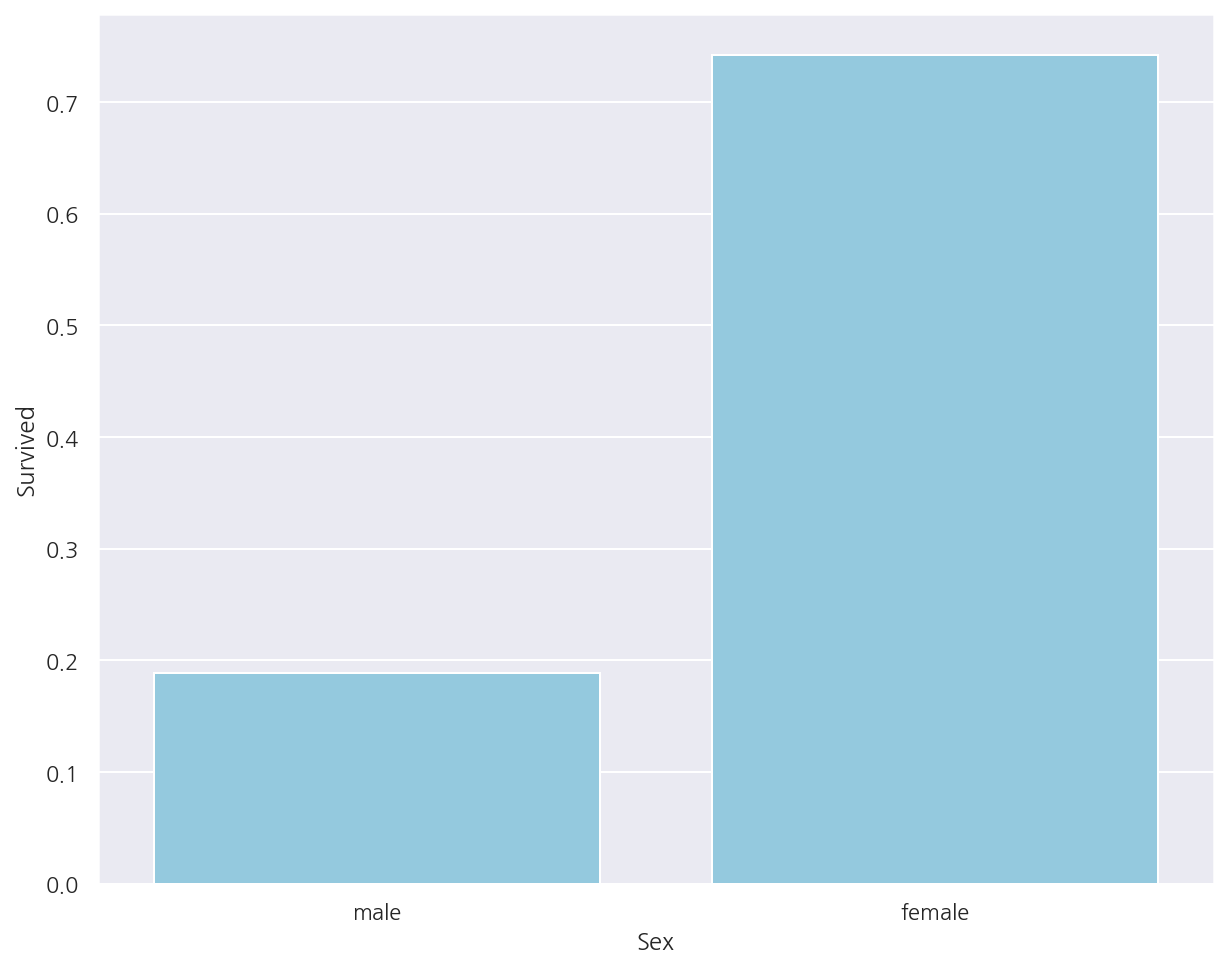

In [29]:
sns.barplot(x = "Sex", y = "Survived", data = titanic_df,
            ci =None, 
            color = "skyblue")
plt.show()

- 여자의 생존확률은 74.20%, 남자의 생존확률은 18.89%로 여자의 생존확률이 높게 나타났다.

**선실 등급, 성별에 따른 생존 확률**

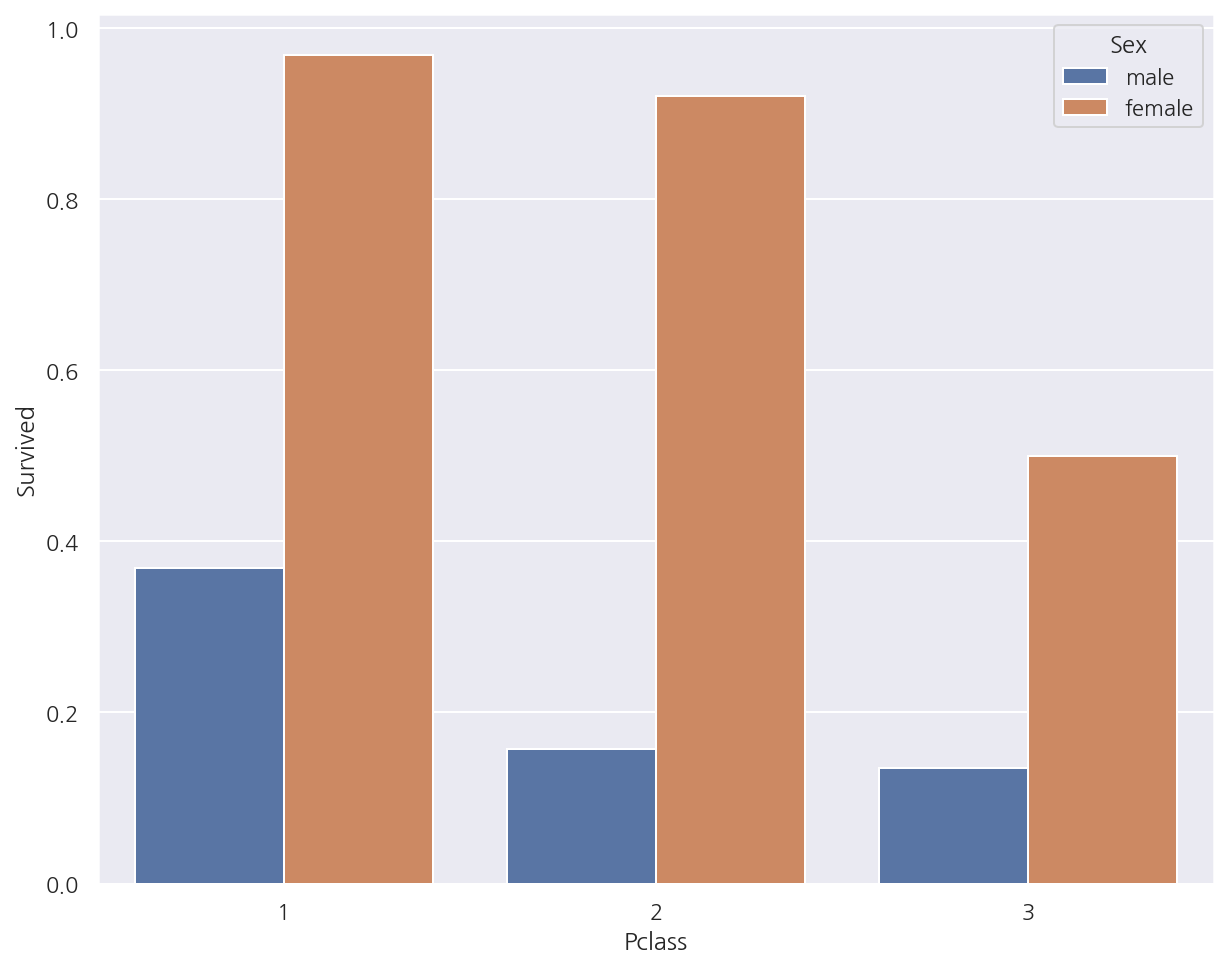

In [30]:
sns.barplot(x = "Pclass", y = "Survived", data = titanic_df,
            ci =None, 
            hue = "Sex")
plt.show()

- 여자의 경우 일등석과 이등석간의 생존 확률 차이가 크지 않으나 삼등석일때 상대적으로 가장 낮았다.


- 남자의 경우 일등석일때 생존 확률이 가장 높으며 이등석, 삼등석 간의 생존 확률 차이는 크지 않았다.

**나이 그룹, 성별에 따른 생존 확률**

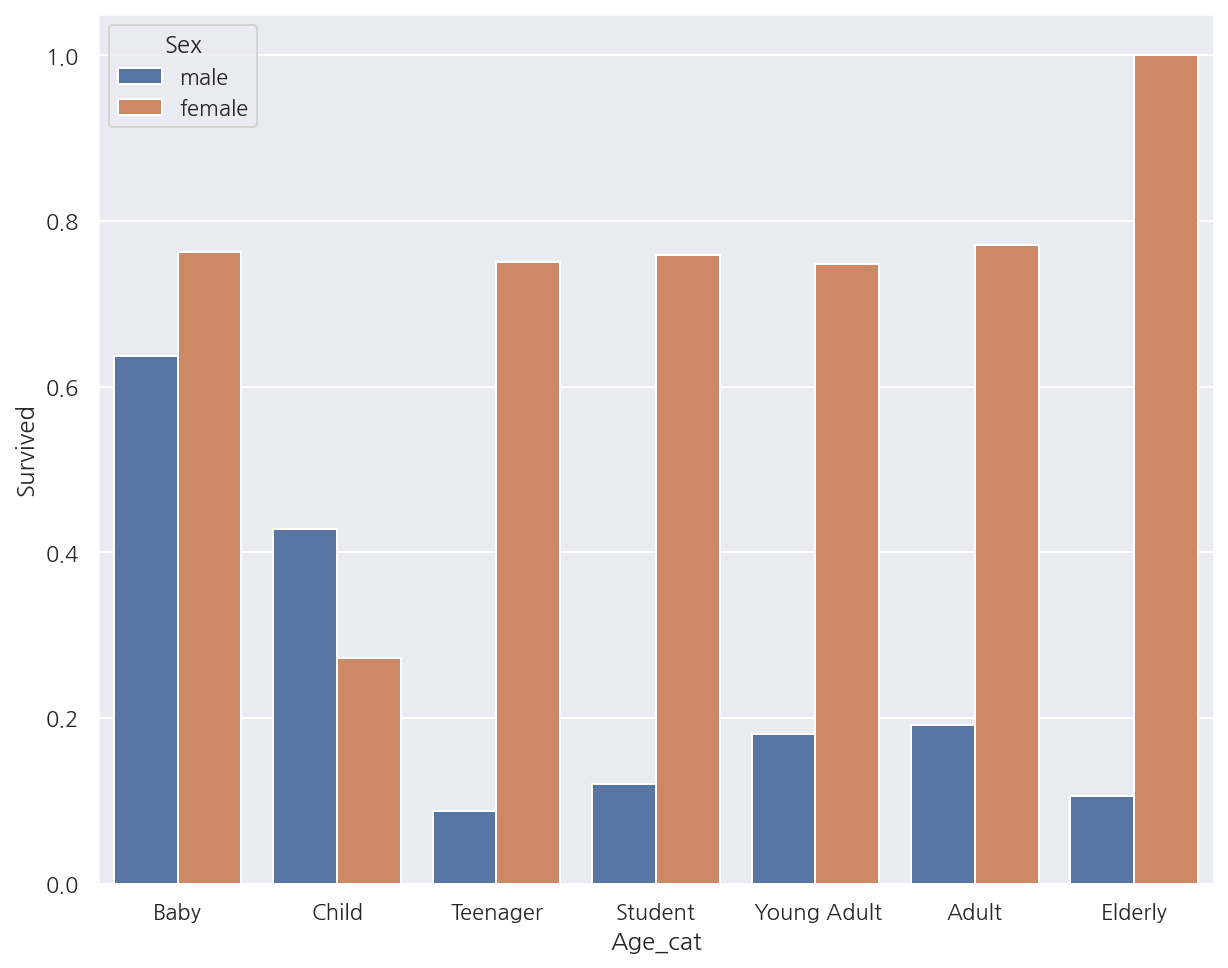

In [31]:
# 나이 그룹 변수 추가
bins = [np.min(titanic_df.Age), 5, 12, 18, 25, 35, 60, np.max(titanic_df.Age)]
labels = ["Baby", "Child", "Teenager", "Student", " Young Adult", "Adult", "Elderly"]

titanic_df["Age_cat"] = pd.cut(titanic_df["Age"], bins, labels=labels)

# 나이 그룹별 생존 확률
sns.barplot(x = "Age_cat", y = "Survived", data = titanic_df,
            ci =None, 
            hue = "Sex")
plt.show()

- 여자의 경우 Child의 생존 확률은 다른 연령대에 비해 낮았으며 Elderly는 가장 높았다.


- 남자의 경우 Elderly의 생존 확률이 가장 낮았으며 Baby의 생존 확률이 가장 높았다.

## 2.4 데이터 편집

지금까지의 데이터 편집과정 및 문자열 변수 인코딩 등의 함수를 생성할 것이다.

In [32]:
# Null 처리
def t_fillna(df):
    df["Age"].fillna(df.Age.mean(), inplace = True)
    df["Cabin"].fillna( "N", inplace = True)
    df["Embarked"].fillna( "N", inplace = True)
    df["Fare"].fillna(0, inplace = True) # Train에서 결측은 없었음
    return df

# 머신러닝 알고리즘에 불필요한 변수 제거
def t_drop_features(df):
    df.drop(["PassengerId", "Name", "Ticket"], axis=1, inplace=True)
    return df

# 레이블 인코딩 처리
def t_cat_encoding(df):
    df["Cabin"] = df["Cabin"].str[:1]
    
    features = ["Cabin", "Sex", "Embarked"]
    
    for f in features:
        le = LabelEncoder()
        le = le.fit(df[f])
        df[f] = le.transform(df[f])
    return df

# 나이 그룹 변수
def t_age_cat(df):
    bins = [np.min(titanic_df.Age), 5, 12, 18, 25, 35, 60, np.max(titanic_df.Age)]
    labels = ["Baby", "Child", "Teenager", "Student", " Young Adult", "Adult", "Elderly"]
    
    df["Age_cat"] = pd.cut(df["Age"], bins, labels=labels)
    return df

def t_transform_features(df, age_add=False):
    t_fillna(df)
    t_drop_features(df)
    t_cat_encoding(df)
    
    if age_add == True:
        t_age_cat(df)
        
    return df

## 2.5 머신러닝

**데이터 다시 불러오기**

In [33]:
titanic_df = pd.read_csv("./titanic_train.csv")
titanic_df = t_transform_features(titanic_df)
titanic_df.head(5)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,7.2500,7,3
1,1,1,0,38.0,1,0,71.2833,2,0
2,1,3,0,26.0,0,0,7.9250,7,3
3,1,1,0,35.0,1,0,53.1000,2,3
4,0,3,1,35.0,0,0,8.0500,7,3


**학습/검증 데이터 분리**

In [34]:
titanic_X = titanic_df.drop("Survived", axis=1)
titanic_y = titanic_df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(titanic_X, titanic_y, test_size=0.2, random_state=11)

**ML 적용**

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# ML 알고리즘 객체 생성
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression()

# DecisionTree 학습/예측/평가
dt_clf.fit(X_train,y_train)
dt_pred = dt_clf.predict(X_test)
acc1 = accuracy_score(y_test, dt_pred)
print(f"DecisionTreeClassifier 정확도: {acc1:.4f}")

# RandomForest 학습/예측/평가
rf_clf.fit(X_train,y_train)
rf_pred = rf_clf.predict(X_test)
acc2 = accuracy_score(y_test, rf_pred)
print(f"RandomForestClassifier 정확도: {acc2:.4f}")

# LogisticRegression 학습/예측/평가
lr_clf.fit(X_train,y_train)
lr_pred = lr_clf.predict(X_test)
acc = accuracy_score(y_test, lr_pred)
print(f"LogisticRegression 정확도: {acc:.4f}")

DecisionTreeClassifier 정확도: 0.7877
RandomForestClassifier 정확도: 0.8547
LogisticRegression 정확도: 0.8492


- RandomForestClassifier의 정확도가 가장 높게 나타났으나 현재는 교차검증 및 최적화 작업을 시행하지 않았다.

**DecisionTreeClassifier 교차 검증**

In [36]:
cv = KFold(5)
accs = []

for i, (train_idx, test_idx) in enumerate(cv.split(titanic_df)):
    X_train, X_test = titanic_X.iloc[train_idx], titanic_X.iloc[test_idx]
    y_train, y_test = titanic_y[train_idx], titanic_y[test_idx]
    
    dt_clf.fit(X_train,y_train)
    dt_pred = dt_clf.predict(X_test)
    acc = accuracy_score(y_test, dt_pred)
    accs.append(acc)
    
    print(f"#{i+1}. 검증 정확도: {acc:.4f}")
    
print(f"##  평균 검증 정확도: {np.mean(accs):.4f}")

#1. 검증 정확도: 0.7542
#2. 검증 정확도: 0.7809
#3. 검증 정확도: 0.7865
#4. 검증 정확도: 0.7697
#5. 검증 정확도: 0.8202
##  평균 검증 정확도: 0.7823


In [37]:
scores = cross_val_score(dt_clf, titanic_X, titanic_y, cv=KFold(5))

for i in range(5):
    print(f"#{i+1}. 검증 정확도: {scores[i]:.4f}")
    
print(f"##  평균 검증 정확도: {np.mean(scores):.4f}")

#1. 검증 정확도: 0.7542
#2. 검증 정확도: 0.7809
#3. 검증 정확도: 0.7865
#4. 검증 정확도: 0.7697
#5. 검증 정확도: 0.8202
##  평균 검증 정확도: 0.7823


**DecisionTreeClassifier GridSearchCV**

In [38]:
# 학습/검증 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(titanic_X, titanic_y, test_size=0.2, random_state=11)

# 하이퍼 파라미터
parameters = {"max_depth": [2,3,5,10],
             "min_samples_split": [2,3,5], "min_samples_leaf": [1,5,8]}

# GridSearchCV
grid_dclf = GridSearchCV(dt_clf, param_grid = parameters, scoring="accuracy", cv=5)
grid_dclf.fit(X_train,y_train)

print("GridSearchCV 최적 하이퍼 파라미터:", grid_dclf.best_params_)
print("GridSearchCV 최고 정확도:", grid_dclf.best_score_.round(4))


# 최적 하이퍼 파라미터로 학습된 estimator로 예측 및 평가
best_dclf = grid_dclf.best_estimator_
dpredictions = best_dclf.predict(X_test)
acc = accuracy_score(y_test,dpredictions)

print(f"검증 데이터 정확도: {acc:.4f}")

GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.7992
검증 데이터 정확도: 0.8715
